# 単語のベクトル表現の仕組み
まずはword2vec, fastTextによる単語のベクトル表現について理解する

## word2vecでの単語のベクトル表現手法
単語にIDを振る作戦の問題点
- one-hot表現が長くなりすぎる
- 単語間の関係性を考慮できない

そこで，単語を数百次元程度の特徴量ベクトルで表現する  

## CBOW
単語のベクトル表現の代表的アルゴリズムに，word2vecがある  
コンセプトは，「単語のベクトル表現をその周囲で頻繁に使われる単語で決定」  
このコンセプトによる手法には主に以下の2つがある
- Continuous Bag-of-Words: CBOW
- Skip-gram

これらの勉強はゼロから始めるDL2でも[勉強](https://nbviewer.jupyter.org/github/fuurin/DLFromScratch2/blob/master/3%E7%AB%A0%20word2vec.ipynb)した

CBOWでは，ある単語の周囲の単語から，その単語を推定するタスクによってベクトル化を行う  
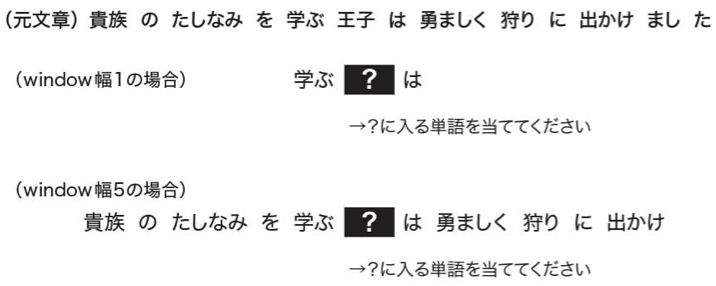

このタスクは，全結合層からなる深層学習のクラス分類で行われる．  
そのモデルの重みWが単語の分散表現になる
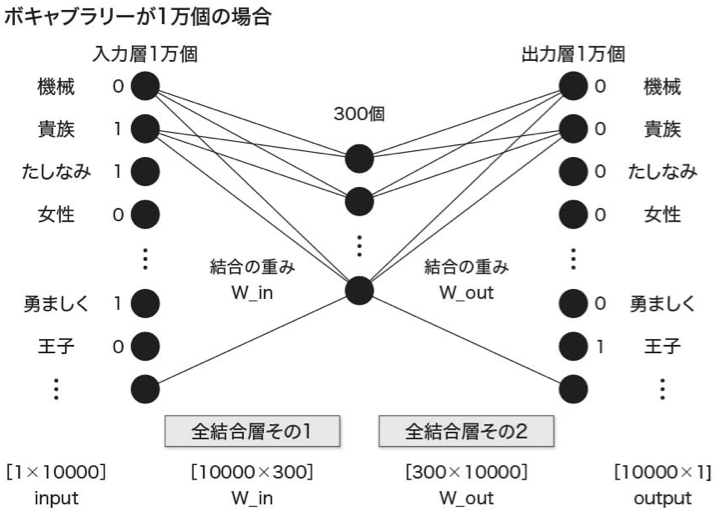

このW_inの行をその単語のベクトル表現として用いる  
(入力がone-hotなので300次元への出力結果そのものになるね)  
(W_outが使われることもある）  
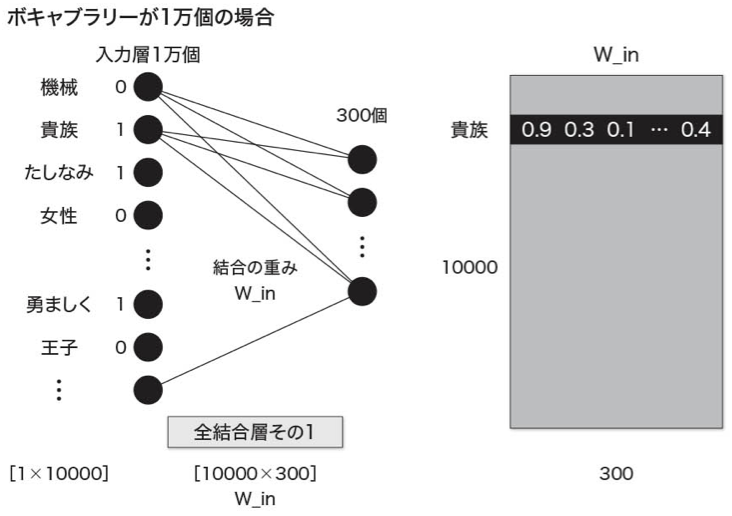

このCBOWをベースとして，「ネガティブサンプリング」や「階層化ソフトマックス」といった技術によって効率的に学習を行う．（ここでは解説しないが，一部の手法はゼロから始めるDL2で[勉強](https://nbviewer.jupyter.org/github/fuurin/DLFromScratch2/blob/master/4%E7%AB%A0%20word2vec%E3%81%AE%E9%AB%98%E9%80%9F%E5%8C%96.ipynb)した．)

## Skip-gram
こちらは，逆にターゲットとなる単語の周囲の単語を推定する  
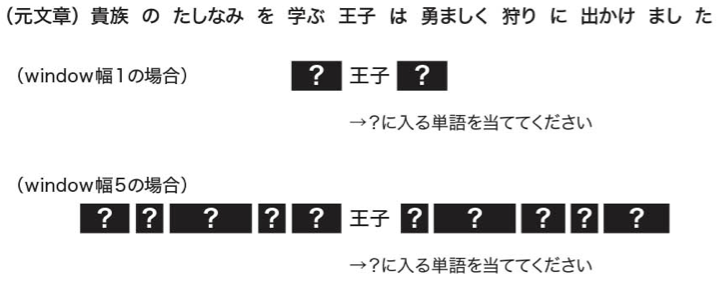

こちらのタスクを解くモデルでは入出力が逆になる  
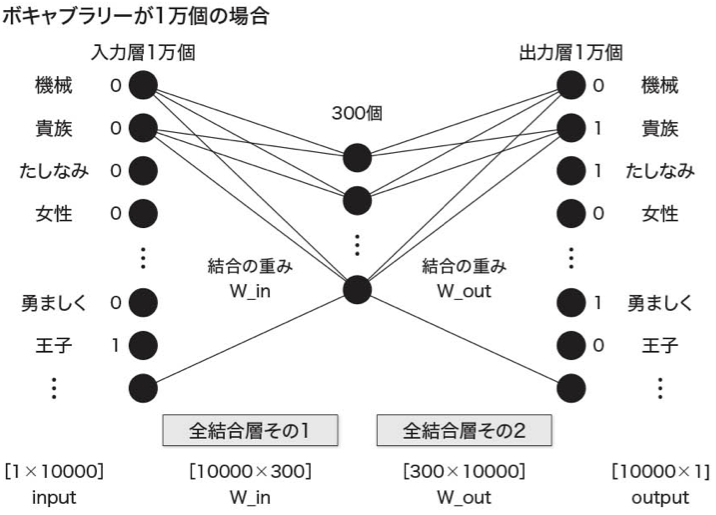

CBOWとSkip-gramでは，Skip-gramの方が難しいタスクであるため，精度は良いが，学習には時間がかかるとされている．  

## fastTextでの単語ベクトル表現
word2vecと同じMikolov氏が2016年に提案  
単語を「サブワード」と呼ばれる概念でさらに分割し，分割された単語ごとにベクトル表現を学習  
例えば，「where」という単語なら  
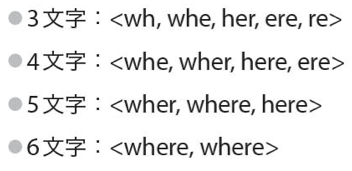

となり，5+4+3+2=14通りのサブワードとなる．  
このサブワードという概念により，未知の単語に強いモデルを作ることができる．  
未知の単語をサブワードに分割することで，既存のサブワードから意味を推定できるためである．  
日本語の場合は，1文字を1つのサブワードの単位とする．  
実際には，fastTextの方がword2vecよりも高速に学習できる様々な工夫がなされている．

# word2vec, fastTextで日本語学習済みモデルを使用する
日本語学習済みモデルを使うと，「姫-女性+男性=王子」のような意味の計算が可能になる

## 前準備
[gensim](https://qiita.com/u6k/items/5170b8d8e3f41531f08a)というトピック分析パッケージをインストール
``` bash
pip install gensim
```
7.1節でentity_vector.model.binとNEologdのmodel.vecを入手しておく

## word2vecの日本語学習済みモデルの使用方法
7.2節と同様にしてtrain_ds, val_ds, test_dsを作成  janomeではなくMeCab+NEologdで分割

In [1]:
import os, re, torchtext, MeCab

In [2]:
data_dir = "../../datasets/ptca_datasets/chapter7"
cache_dir = os.path.join(data_dir, "vector_cache")

In [3]:
def tokenizer_mecab(text, neologd_path='/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd'):
    m_t = MeCab.Tagger(f'-Owakati -d {neologd_path}') # wakatiを使って品詞情報をなくす
    text = m_t.parse(text)
    return text.strip().split()

def preprocessing_text(text):
    text = re.sub('\r', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(' ', '', text)
    text = re.sub('　', '', text)
    text = re.sub(r'[0-9 ０-９]', '0', text)
    return text

def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_mecab(text)
    return ret

max_length = 25
TEXT = torchtext.data.Field(
    sequential=True,
    tokenize=tokenizer_with_preprocessing,
    use_vocab=True,
    lower=True,
    include_lengths=True,
    batch_first=True,
    fix_length=max_length
)

LABEL = torchtext.data.Field(
    sequential=False,
    use_vocab=False
)

In [4]:
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path=data_dir,
    train='text_train.tsv',
    validation='text_val.tsv',
    test='text_test.tsv',
    format='tsv',
    fields=[('Text', TEXT), ('Label', LABEL)]
)

print('訓練データの数', len(train_ds))
print('訓練データ[0]', vars(train_ds[0]))
print('訓練データ[1]', vars(train_ds[1]))

訓練データの数 4
訓練データ[0] {'Text': ['王', 'と', '王子', 'と', '女王', 'と', '姫', 'と', '男性', 'と', '女性', 'が', 'い', 'まし', 'た', '。'], 'Label': '0'}
訓練データ[1] {'Text': ['機械学習', 'が', '好き', 'です', '。'], 'Label': '1'}


続いて，日本語Wikipediaエンティティベクトルをtorchtextで読み込める形式に変換して保存する

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(
    os.path.join(data_dir, 'entity_vector', 'entity_vector.model.bin'),
    binary=True
)

model.wv.save_word2vec_format(os.path.join(data_dir, 'japanese_word2vec_vectors.vec'))

次に,torchtextの単語ベクトルとして読み込む設定を行う  
``` text
多分ここで.vector_cacheとかいう激重ファイルが入るディレクトリが作成されるので，絶対.gitignoreしておく
もしくは，cache=cache_dirを設定し，プロジェクトの外に追いやっておく
```

In [6]:
from torchtext.vocab import Vectors

japanese_word2vec_vectors = Vectors(
    name=os.path.join(data_dir, 'japanese_word2vec_vectors.vec'),
    cache=cache_dir
)

print("1単語を表現する次元数:", japanese_word2vec_vectors.dim)
print("単語数:", len(japanese_word2vec_vectors.itos))

100%|█████████▉| 1014216/1015474 [01:17<00:00, 13110.26it/s]

1単語を表現する次元数: 200
単語数: 1015474


100%|█████████▉| 1014216/1015474 [01:30<00:00, 13110.26it/s]

100万単語のデータを使い続けるのは大変なのでtrain_dsのボキャブラリの49単語にのみこのベクトル表現を与える

In [7]:
TEXT.build_vocab(train_ds,
    vectors=japanese_word2vec_vectors,
    min_freq=1
)

print(TEXT.vocab.vectors.shape)
print(TEXT.vocab.vectors)
print(TEXT.vocab.stoi)

torch.Size([49, 200])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 2.6023, -2.6357, -2.5822,  ...,  0.6953, -1.4977,  1.4752],
        ...,
        [-2.8353,  2.5609, -0.5348,  ...,  0.4602,  1.4669, -2.1255],
        [-1.5885,  0.1614, -0.6029,  ..., -1.7545, -1.2462,  2.3034],
        [-0.0448, -0.1304,  0.0329,  ...,  0.0825, -0.1386,  0.0417]])
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fa574fdfa58>>, {'<unk>': 0, '<pad>': 1, 'と': 2, '。': 3, 'な': 4, 'の': 5, '文章': 6, '、': 7, 'が': 8, 'し': 9, 'を': 10, 'いる': 11, 'か': 12, 'て': 13, 'ます': 14, '分類': 15, '本章': 16, '評価': 17, '0': 18, 'い': 19, 'から': 20, 'する': 21, 'その': 22, 'た': 23, 'で': 24, 'です': 25, 'に': 26, 'に対して': 27, 'は': 28, 'まし': 29, 'クラス': 30, 'ネガティブ': 31, 'ポジティブ': 32, 'モデル': 33, 'レビュー': 34, '値': 35, '取り組み': 36, '商品': 37, '女性': 38, '女王': 39, '好き': 40, '姫': 41, '構築': 42, '機械学習': 43, '王':

姫-女性+男性に王子が近くなるのかを確認  
類似度の計算にはコサイン類似度$a\cdot b/(||a||\cdot ||b||)$を使用し，比較対象を「機械学習」とする

In [8]:
import torch.nn.functional as F

vecs = TEXT.vocab.vectors
sim = F.cosine_similarity

# 姫 - 女性 + 男性
tensor_calc = vecs[41] - vecs[38] + vecs[46]

# 計算結果とのコサイン類似度を計算
print("女王", sim(tensor_calc, vecs[39], dim=0))
print("王", sim(tensor_calc, vecs[44], dim=0))
print("王子", sim(tensor_calc, vecs[45], dim=0))
print("機械学習", sim(tensor_calc, vecs[43], dim=0))

女王 tensor(0.3840)
王 tensor(0.3669)
王子 tensor(0.5489)
機械学習 tensor(-0.1404)


計算結果は，王子との類似度が最も高くなり，単語間の関係が表されていることがわかった

## fastTextの日本語学習済みモデルを使用する実装
torchtextにもfastTextによる日本語の学習済みモデルが用意されているが，精度が低いらしいので，@Hironsanさんが公開しているモデルを使用  
上記のコードと同様にして，torchtext.vocab.Vectorsで読み込み，tokenizer_with_preprocessingで使用する  

In [ ]:
from torchtext.vocab import Vectors

japanese_fasttext_vectors = Vectors(
    name=os.path.join(data_dir, 'model.vec'),
    cache=cache_dir
)

print("1単語を表現する次元数:", japanese_fasttext_vectors.dim)
print("単語数:", len(japanese_fasttext_vectors.itos))

In [10]:
TEXT.build_vocab(train_ds,
    vectors=japanese_fasttext_vectors,
    min_freq=1
)

print(TEXT.vocab.vectors.shape)
print(TEXT.vocab.vectors)
print(TEXT.vocab.stoi)

torch.Size([49, 300])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0182, -0.0894, -0.1011,  ..., -0.0410, -0.0735,  0.0045],
        ...,
        [ 0.0161, -0.0172, -0.2945,  ..., -0.0038,  0.1588, -0.0076],
        [-0.2099,  0.1631, -0.0182,  ..., -0.4823,  0.0375,  0.0088],
        [-0.2762,  0.2986,  0.0511,  ..., -0.1052, -0.1779, -0.1957]])
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fa479e54cc0>>, {'<unk>': 0, '<pad>': 1, 'と': 2, '。': 3, 'な': 4, 'の': 5, '文章': 6, '、': 7, 'が': 8, 'し': 9, 'を': 10, 'いる': 11, 'か': 12, 'て': 13, 'ます': 14, '分類': 15, '本章': 16, '評価': 17, '0': 18, 'い': 19, 'から': 20, 'する': 21, 'その': 22, 'た': 23, 'で': 24, 'です': 25, 'に': 26, 'に対して': 27, 'は': 28, 'まし': 29, 'クラス': 30, 'ネガティブ': 31, 'ポジティブ': 32, 'モデル': 33, 'レビュー': 34, '値': 35, '取り組み': 36, '商品': 37, '女性': 38, '女王': 39, '好き': 40, '姫': 41, '構築': 42, '機械学習': 43, '王':

In [11]:
import torch.nn.functional as F

vecs = TEXT.vocab.vectors
sim = F.cosine_similarity

# 姫 - 女性 + 男性
tensor_calc = vecs[41] - vecs[38] + vecs[46]

# 計算結果とのコサイン類似度を計算
print("女王", sim(tensor_calc, vecs[39], dim=0))
print("王", sim(tensor_calc, vecs[44], dim=0))
print("王子", sim(tensor_calc, vecs[45], dim=0))
print("機械学習", sim(tensor_calc, vecs[43], dim=0))

女王 tensor(0.3650)
王 tensor(0.3461)
王子 tensor(0.5531)
機械学習 tensor(0.0952)


fastTextでも単語間の関係がしっかりとベクトル表現に反映されていることがわかる

以上，本節ではword2vecとfastTextについて説明し，それらの日本語学習済みモデルを用いて日本語の単語ベクトル表現を取得する実装の説明を行なった．  
次節では，IMDb(Internet Movie Database)という映画のレビューテキストデータから感情分析を行う方法を解説・実装する